In [231]:
#we define an "incremented pd_code" if it is of the form (a, b, a+1, b+1) or (a, b+1, a+1, b). This is achieved by walking around the knot and labelling each new 'strand'
#with an incrementing indexing number as you pass over or under a crossing.

#method for getting an incremented pd code of a knot as a list. sage takes pd_code lists as inputs for knots.
def knot_from_table(k,n):
    import snappy
    def sage_pd_code(link):
        pd = link.PD_code()
        return [[element + 1 for element in tup] for tup in pd]
    L = snappy.Link(str(k) + '_' + str(n))
    snappd = sage_pd_code(L)
    K = Knot(snappd)
    return K

#returns the list of regions with no negative values.
def abs_regions(self):
    regions = self.regions()
    return [set(abs(element) for element in reg) for reg in regions]

#returns the pd_code as a set. Used supplementarily to aid in intersection and difference checks.
def cross(self):
    return [set(pd) for pd in self.pd_code()]


def weight(tuple):
    if int(tuple[0]) % 2 == 1:
        return +1
    else:
        return -1

#returns the complement of two sets' intersection.
def complement_intersection(set1, set2):
    return set(set1).difference(set2)

#returns the length of the intersection of two sets. used primarily for the weights of the crossings, as a set is unordered.
def common_elements(lst, s):
    list_set = set(lst)
    common = list_set.intersection(s)
    return len(common)

#quick graph
def decorate_and_plot_graph(g):
    plot = g.plot(layout = 'spring', dist = 0.15, iterations = 200, edge_labels=True)
    plot.show(figsize = 6)

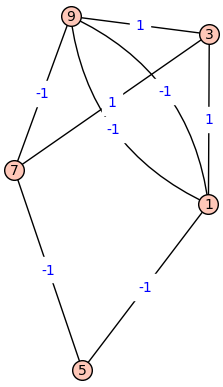

In [233]:
from collections import defaultdict
import sage.graphs.graph as graph

K = knot_from_table(8,20)

def tait_graph(K):
    regions = abs_regions(K)
    crossings = cross(K)
    pd_code = K.pd_code()
    #print(pd_code)
    #print(crossings)
    #print(abs_regions(K))
    faces_static = {index: tuple(region) for index, region in enumerate(regions)}
    faces = {tuple(region): index for index, region in enumerate(regions)}
    #print(faces)
    #print(faces_static)
    edges = []
    seen = []
    #seen_weights = []
    for ind in range(len(faces)):
        common_list = [c for c in crossings if len(intersection(faces_static[ind], c)) == 2]

        weight_check = [p for p in pd_code for c in common_list if common_elements(p,c) == 4]

        common_list_weights = [weight(p) for p in weight_check]

        """
        for p in weight_check:
            seen_weights.append(p)
        """

        #print(common_list)
        #print(len(common_list) == len(common_list_weights))
        set_diff = [complement_intersection(c, faces_static[ind]) for c in common_list]

        neighboring_regions = [
            (key, value)
            for key, value in faces_static.items()
            for s in set_diff if len(set(value).intersection(s)) == 2
        ]

        #print(neighboring_regions)
        for i in range(len(neighboring_regions)):
            if neighboring_regions[i][1] not in seen:
                edges.append((faces[faces_static[ind]], neighboring_regions[i][0], common_list_weights[i]))
        seen.append(faces_static[ind])
        #print(seen)
        #print(f"edges = {edges}")
    
    G = graph.Graph(edges, multiedges=True)
    components = G.connected_components()
    if len(components) > 2:
        raise ValueError('The link diagram is split.')
    return G.subgraph(components[0]), G.subgraph(components[1])
    

In [ ]:
black, white = tait_graph(K)

decorate_and_plot_graph(white)